In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)


from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from tools import get_tools_output
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import all_tools
from chat_history import save_chat_history, load_chat_history

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def analyst_router(state) -> Literal["call_tool", "__end__", "data_collector"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if last_message.tool_calls:
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    else:
        return "continue"
    
    
def data_collector_router(state) -> Literal["call_tool", "reporter"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "reporter" in last_message.content:
        return "reporter"
    else:
        return "continue"
    
    
def reporter_router(state) -> Literal["call_tool", "data_collector"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if last_message.tool_calls:
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    else:
        return "continue"


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    analyst_router,
    {
        "call_tool": "call_tool", 
        "data_collector":"data_collector",
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    data_collector_router,
    {
        "call_tool": "call_tool", 
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    reporter_router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()


def submitUserMessage(user_input: str, user_id:str="test", keep_chat_history:bool=False, return_reference:bool=False, verbose=False) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": 20},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            # print(e)
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

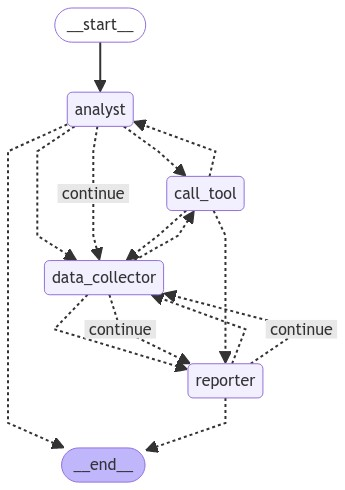

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
# import utils
result = submitUserMessage("วิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว", keep_chat_history=True, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

In [5]:
submitUserMessage("ต้องการขายข้าวในราคา 300", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_ZugoyWUoA9GjH2ozmIMHd7t9)
 Call ID: call_ZugoyWUoA9GjH2ozmIMHd7t9
  Args:
    input_dict: {'base_price': 300, 'category': 'Rice Bowl'}
  find_place_from_text (call_Q3eEY2O9imqCSFJxSKmD2wdu)
 Call ID: call_Q3eEY2O9imqCSFJxSKmD2wdu
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	635	190,620
5	2,335	700,410
52	686	205,740

================================== Ai Message ==================================
Name: analyst

FINALANSWER

การขายข้าวในราคา 300 บาทที่ลุมพินี เซ็นเตอร์ ลาดพร้าว มีการคาดการณ์ยอดขายดังนี้:

- **การคาดการณ์ยอดขาย**:
  - **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 635 รายการ, ยอดขายประมาณ 190,620 บาท
  - **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,335 รายการ, ยอดขายป

('\n\nการขายข้าวในราคา 300 บาทที่ลุมพินี เซ็นเตอร์ ลาดพร้าว มีการคาดการณ์ยอดขายดังนี้:\n\n- **การคาดการณ์ยอดขาย**:\n  - **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 635 รายการ, ยอดขายประมาณ 190,620 บาท\n  - **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,335 รายการ, ยอดขายประมาณ 700,410 บาท\n  - **ปีที่ 1**: จำนวนการสั่งซื้อ 686 รายการ, ยอดขายประมาณ 205,740 บาท\n\n### ข้อเสนอแนะ\n- **ราคา 300 บาท**: เป็นราคาที่สูงกว่าคู่แข่งในตลาด ซึ่งอาจทำให้การขายมีความท้าทาย แต่ถ้าคุณมีคุณภาพและบริการที่ดี อาจดึงดูดลูกค้าได้\n- **การวิเคราะห์คู่แข่ง**: ควรตรวจสอบราคาของคู่แข่งในพื้นที่เพื่อให้แน่ใจว่าราคานี้สามารถแข่งขันได้\n\nหากคุณมีคำถามเพิ่มเติมหรือต้องการข้อมูลเพิ่มเติมเกี่ยวกับการเปิดร้านอาหารในพื้นที่นี้ โปรดแจ้งให้ทราบ!',
 'sale projection of Rice Bowl:\nweek\tnumber of order\tsale(forecast)\n1\t635\t190,620\n5\t2,335\t700,410\n52\t686\t205,740\n\n')

In [6]:
submitUserMessage("if i it passible to sell rice 10 bath each.", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_1JcmbM46F3KlhKaCz9v4pJPv)
 Call ID: call_1JcmbM46F3KlhKaCz9v4pJPv
  Args:
    input_dict: {'base_price': 10, 'category': 'Rice Bowl'}
  find_place_from_text (call_Zvj1Dymr21QURzg9R7TZ62ue)
 Call ID: call_Zvj1Dymr21QURzg9R7TZ62ue
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	849	8,489
5	2,252	22,521
52	800	8,003

================================== Ai Message ==================================
Name: analyst

FINALANSWER

การขายข้าวในราคา 10 บาทต่อจานที่ลุมพินี เซ็นเตอร์ ลาดพร้าวนั้นเป็นไปได้ โดยมีการคาดการณ์ยอดขายดังนี้:

### การคาดการณ์ยอดขายข้าว (Rice Bowl)
- **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 849 รายการ, ยอดขายประมาณ 8,489 บาท
- **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ

('\n\nการขายข้าวในราคา 10 บาทต่อจานที่ลุมพินี เซ็นเตอร์ ลาดพร้าวนั้นเป็นไปได้ โดยมีการคาดการณ์ยอดขายดังนี้:\n\n### การคาดการณ์ยอดขายข้าว (Rice Bowl)\n- **สัปดาห์ที่ 1**: จำนวนการสั่งซื้อ 849 รายการ, ยอดขายประมาณ 8,489 บาท\n- **สัปดาห์ที่ 5**: จำนวนการสั่งซื้อ 2,252 รายการ, ยอดขายประมาณ 22,521 บาท\n- **ปีที่ 1**: จำนวนการสั่งซื้อ 800 รายการ, ยอดขายประมาณ 8,003 บาท\n\n### ข้อเสนอแนะ\n- **ราคา 10 บาท**: เป็นราคาที่ต่ำมากเมื่อเปรียบเทียบกับคู่แข่งในตลาด ซึ่งอาจทำให้คุณมีปัญหาในเรื่องของกำไร\n- **การวิเคราะห์คู่แข่ง**: ควรตรวจสอบราคาของคู่แข่งในพื้นที่เพื่อให้แน่ใจว่าราคานี้สามารถแข่งขันได้และยังคงมีกำไร\n\nหากคุณมีคำถามเพิ่มเติมหรือต้องการข้อมูลเพิ่มเติมเกี่ยวกับการเปิดร้านอาหารในพื้นที่นี้ โปรดแจ้งให้ทราบ!',
 'sale projection of Rice Bowl:\nweek\tnumber of order\tsale(forecast)\n1\t849\t8,489\n5\t2,252\t22,521\n52\t800\t8,003\n\n')